In [6]:
%load_ext autoreload
%autoreload 2
from helpers import *
data_folder = './DATA/'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /home/julian/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.
[nltk_data] Downloading package words to /home/julian/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/julian/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /home/julian/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/julian/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Table of Contents
- [First Analysis of the character data](#section-6)
    - [A) Analysis of actors' gender and age](#subsection-6.1)
    - [B) Personas Analysis](#subsection-6.2)

# First Analysis of the character data
<a id='section-6'></a>

## A) Analysis of actors' gender and age
<a id='subsection-6.1'></a>

#### Proportion analysis
**What's the proportion of female actors in movies per year?**
We wonder if the proportion of female actors' increase over the years, which is what we would expect.

In [2]:
characters_data = pd.read_csv(data_folder+'characters_data.csv')

C:\Users\lucil\AppData\Local\Temp\ipykernel_3804\3796714083.py:1: DtypeWarning: Columns (2,3,5) have mixed types. Specify dtype option on import or set low_memory=False.
  characters_data = pd.read_csv(data_folder+'characters_data.csv')


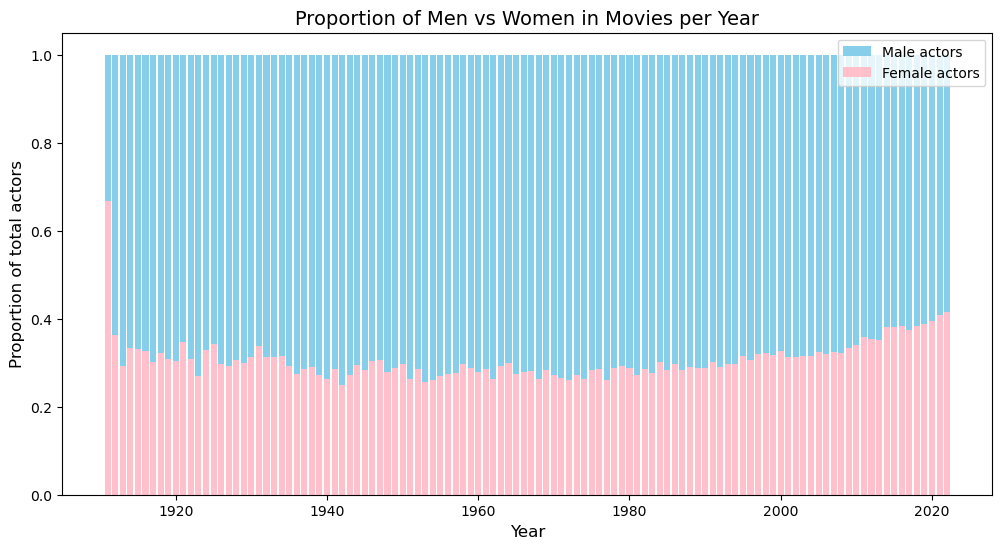

In [3]:
# group the movies by year
#characters_data['release_date'] = pd.to_datetime(characters_data['release_date'])
characters_grouped_by_year = characters_data.groupby(characters_data['release_date'])

# Calculate the proportion of men and women per year
proportion_female = characters_grouped_by_year['actor_gender'].apply(lambda x: (x == 'F').sum() / len(x))
proportion_male = 1 - proportion_female

# Plotting the proportion of men vs women per year as a stacked bar chart
plt.figure(figsize=(12, 6))
plt.bar(proportion_male.index, proportion_male.values, bottom=proportion_female.values, label='Male actors',
        color='skyblue')
plt.bar(proportion_female.index, proportion_female.values, label='Female actors', color='pink')
plt.title('Proportion of Men vs Women in Movies per Year', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Proportion of total actors', fontsize=12)
plt.legend()
plt.show()

Interestingly, the proportion of women over the decades stayed fairly constant, graphically, between 30% and 40%. This constrasts with what we expected as we would think that women representation would get better over the years. Nonetheless, it seems that the proportion of female actors started to increase from the beginning of the 21st century to the 2020s'.

However, it is important to note that this preliminary analysis does not contain confidence intervals or any statistical analysis to show the significance of the difference. Here we just look at the global trend. We will perform statistical analysis in later steps of the project.

Nevertheless, this result doesn't mean that each movie has approximately 30-40% of women in their actors cast. This result might be biased by movies that have an extremely low/high proportion of women versus movies that have a balanced actors cast. To determine if that is the case, let's plot the proportion of movies per year that have 0-25% actresses, 25-50%, 50-75% or 75-100% actresses. Are female actors represented equally in every movies or is there a discrepency between movies released in the same year?

In [4]:
# number of movies per year
number_movies_per_year_character = characters_grouped_by_year.size()

# group by year and by movie
characters_grouped_by_year_and_movie = characters_data.groupby([characters_data['release_date'], 'name'])

# Calculate the proportion of men and women per year per movie
proportion_female_per_movie = \
    characters_grouped_by_year_and_movie['actor_gender'].apply(lambda x: (x == 'F').sum() / len(x))
proportion_male_per_movie = 1 - proportion_female_per_movie

# Convert the Series to a DataFrame for easier data handling in later analysis
female_proportions = proportion_female_per_movie.reset_index()

# Rename the columns if needed
female_proportions.columns = ['release_date', 'name', 'proportion_female']

In [5]:
#Lists to store in which category each movie belongs to per year
below_25_per_year = []
quarter_50_per_year = []
half_75_per_year = []
above_75_per_year = []

# Iterate through each year in the index of female_proportions
for year, proportions in female_proportions.groupby('release_date'):

    # Count movies in different categories for the current year
    below_25 = len(proportions[proportions['proportion_female'] <= 0.25])
    quarter_50 = len(proportions[(proportions['proportion_female'] > 0.25) &
                                 (proportions['proportion_female'] <= 0.5)])
    half_75 = len(proportions[(proportions['proportion_female'] > 0.5) &
                              (proportions['proportion_female'] <= 0.75)])
    above_75 = len(proportions[proportions['proportion_female'] > 0.75])

    # Calculate proportions for each category
    total_movies = len(proportions)
    proportion_below_25 = below_25 / total_movies
    proportion_quarter_50 = quarter_50 / total_movies
    proportion_half_75 = half_75 / total_movies
    proportion_above_75 = above_75 / total_movies

    # Append proportions to respective lists
    below_25_per_year.append(proportion_below_25)
    quarter_50_per_year.append(proportion_quarter_50)
    half_75_per_year.append(proportion_half_75)
    above_75_per_year.append(proportion_above_75)

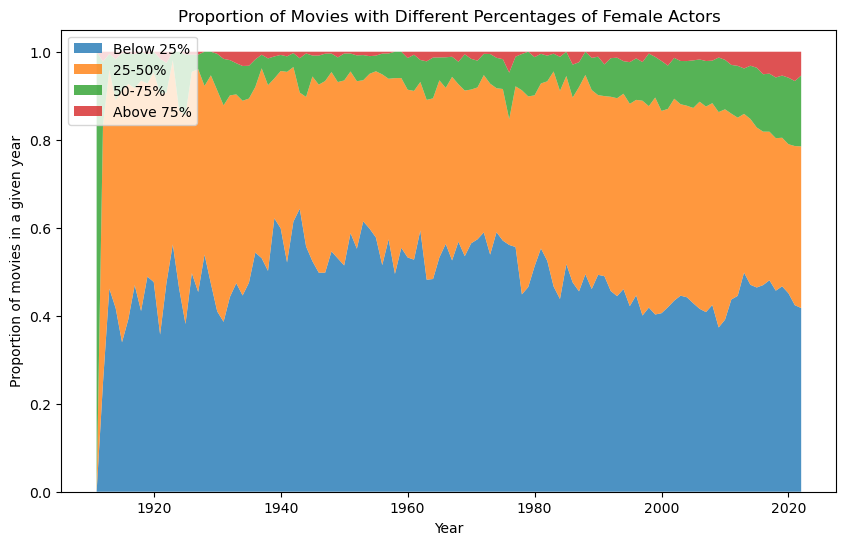

In [6]:
# Extract unique years from the 'release_date' column of the female_proportions DataFrame
unique_years = female_proportions['release_date'].unique()

# Convert the unique years to a list
years = list(unique_years)

# Data for stack plot
categories = ['Below 25%', '25-50%', '50-75%', 'Above 75%']
data = [below_25_per_year, quarter_50_per_year, half_75_per_year, above_75_per_year]

# Create a stack plot
plt.figure(figsize=(10, 6))
plt.stackplot(years, data, labels=categories, alpha=0.8)
plt.xlabel('Year')
plt.ylabel('Proportion of movies in a given year')
plt.title('Proportion of Movies with Different Percentages of Female Actors')
plt.legend(loc='upper left')
plt.show()

We can observe that a vast majority of movies have less than 50% of women actresses in their cast. Actually, over the years, a vast majority of movies (graphically, approximately 85%) have less than 50% female actors in their cast. Thus, even though overall the proportion of women seems to be close to 30-40% over the years, they are largely underrepresented in the vast majority of movies.
However, it might be interesting to note that from 2000 onwards there are more movies with a majority of women actors in their cast, miroring the trend of the overall increase in women's proportion in movies

Yet, it is important to note again that this preliminary analysis does not contain confidence intervals or any statistical analysis to show the significance of the differences. Here we just look at the global trend. We will perform statistical analysis in later steps of the project.

#### Age analysis
**What's the age difference of female actors in movies compared to male actors over the years? Are female actors significantly younger than male actors?**

In [7]:
# drop the actors with NaN as age but also actors with negative ages (which appeared in 1910)
character_age = characters_data.dropna(subset=['actor_age']).copy()
character_age = character_age[character_age['actor_age'] >= 0] # remove actors with a negative age

In [8]:
# Group by year and gender
characters_age_by_year_gender = character_age.groupby([character_age['release_date'], 'actor_gender'])

# Calculate average age and standard deviation of age for each gender per year
gender_age_stats_per_year = characters_age_by_year_gender['actor_age'].agg(['mean', 'sem'])

# Reset the index to make the grouped columns accessible for further analysis or visualization
gender_age_stats_per_year.reset_index(inplace=True)

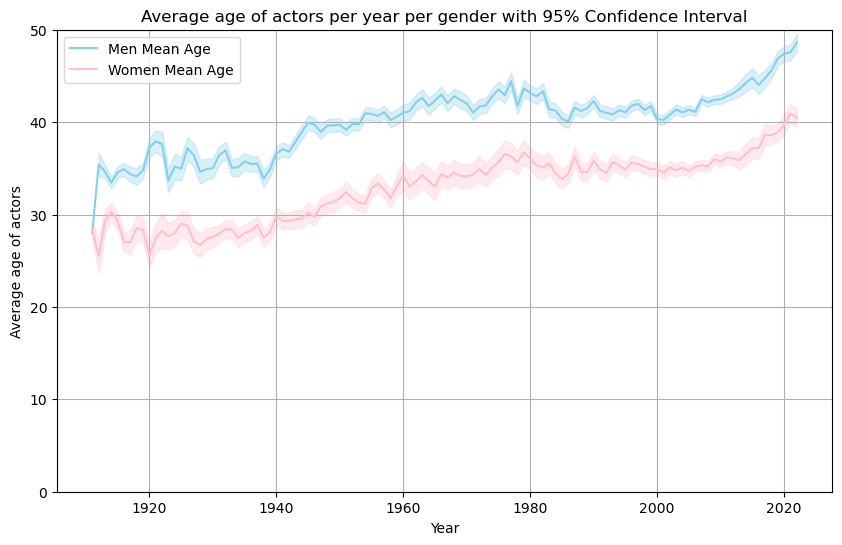

In [9]:
# Filter data for men and women separately for easier handling
men_data = gender_age_stats_per_year[gender_age_stats_per_year['actor_gender'] == 'M'].copy()
women_data = gender_age_stats_per_year[gender_age_stats_per_year['actor_gender'] == 'F'].copy()

# Calculate 95% confidence interval for men
men_data['lower_bound'] = men_data['mean'] - 1.96 * men_data['sem']
men_data['upper_bound'] = men_data['mean'] + 1.96 * men_data['sem']

# Calculate 95% confidence interval for women
women_data['lower_bound'] = women_data['mean'] - 1.96 * women_data['sem']
women_data['upper_bound'] = women_data['mean'] + 1.96 * women_data['sem']

# Plotting for men
plt.figure(figsize=(10, 6))
plt.plot(men_data['release_date'], men_data['mean'], label='Men Mean Age', color='skyblue')
plt.fill_between(men_data['release_date'], men_data['lower_bound'], men_data['upper_bound'],
                 alpha=0.3, color='skyblue')

# Plotting for women
plt.plot(women_data['release_date'], women_data['mean'], label='Women Mean Age', color='pink')
plt.fill_between(women_data['release_date'], women_data['lower_bound'], women_data['upper_bound'],
                 alpha=0.3, color='pink')
plt.xlabel('Year')
plt.ylabel('Average age of actors')
plt.title('Average age of actors per year per gender with 95% Confidence Interval')
plt.legend()
plt.ylim([0, 50])
plt.grid(True)
plt.show()

Between approximately 1930 and 2020, female actors are significantly younger than men at the 5% significance level. The results are not significantly different before 1930 as the 95% confidence intervals overlap. We can see that the average age of actors increase over time (both for men and women). This might be because of the long career span of actors as they usually play in several movies over the year. Thus, the actors in 1960 might be the same as the ones in 1980, explaining why the average age of actors increases.

## B) Personnas Analysis
<a id='subsection-6.2'></a>

**What personas are associated with movie characters interpreted by male and female actors? Are female characters (so female actors) mostly associated with beauty, stupidity, weakness and sexualized and men mostly associated with heroism, adventure, strength...?**

In [10]:
# For the following analysis, drop all the characters that don't have personas
characters_data_personnas_noNA = characters_data.dropna(subset=['personnas']).copy()
display(characters_data_personnas_noNA)

,character_ID,wikipedia_ID,freebase_ID,actor_ethnicity,actor_name,personnas,IMDB_ID,character_name,actor_gender,name,release_date,box_office_revenue,actor_age
396,397,196176.0,/m/01bwgr,/m/041rx,dustin hoffman,tranquil_fury,tt0067800,David Sumner,M,Straw Dogs,1971.0,11148828.0,34.0
1521,1522,1157158.0,/m/04c13q,NaN,edward norton,granola_person,tt0266452,Sheldon Mopes,M,Death to Smoochy,2002.0,8382938.0,33.0
1890,1891,504242.0,/m/02j9_2,/m/041rx,david krumholtz,playful_hacker,tt0379786,Mr. Universe,M,Serenity,2005.0,NaN,27.0
2231,2232,6917005.0,/m/0gwypk,/m/041rx,matthew broderick,charmer,tt0293437,Professor Harold Hill,M,The Music Man,2003.0,NaN,41.0
2810,2811,445066.0,/m/0299hs,NaN,ronny cox,corrupt_corporate_executive,tt0093870,Dick Jones,M,RoboCop,1987.0,53424681.0,49.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
223974,223975,2688769.0,/m/07y2zw,NaN,laura san giacomo,ophelia,tt0102744,Crazy Cora,F,Quigley Down Under,1990.0,21413105.0,29.0
224754,224755,101954.0,/m/0pv3x,/m/0d7wh,colin firth,crazy_jealous_guy,tt0116209,Geoffrey Clifton,M,The English Patient,1996.0,NaN,36.0
224941,224942,9513043.0,/m/02ph9tm,/m/041rx,adam sandler,warrior_poet,tt0960144,Zohan,M,You Don't Mess with the Zohan,2008.0,199936011.0,42.0
227083,227084,52549.0,/m/0dtfn,/m/01qhm_,harrison ford,charmer,tt0076759,Han Solo,M,Star Wars Episode IV: A New Hope,1977.0,460998507.0,35.0


In [11]:
# Check values in the "actor_gender" column to make sure it is populated
characters_data_personnas_noNA.loc[characters_data_personnas_noNA.actor_gender.isna(), "actor_gender"] = "NA"
display(characters_data_personnas_noNA.groupby("actor_gender").count().actor_name)

actor_gender
F     59
M    356
Name: actor_name, dtype: int64

From this very simple line, we can already see that out of the 415 characters, only 59 are played by women, which is already a poor representation.

In [12]:
# split the dataframe in 2: one for males and one for women, which is easier for the subsequent analysis
male_personnas_data = characters_data_personnas_noNA[characters_data_personnas_noNA['actor_gender'] == 'M'].copy()
female_personnas_data = characters_data_personnas_noNA[characters_data_personnas_noNA['actor_gender'] == 'F'].copy()

In [13]:
# print the female personas with their number of occurance
unique_female_personnas_counts = female_personnas_data["personnas"].explode().value_counts()
# Sort the unique_personnas_counts Series by the count in descending order
sorted_female_personnas_counts = unique_female_personnas_counts.sort_values(ascending=False)
sorted_female_personnas_counts

personnas
dumb_blonde                 9
brainless_beauty            7
final_girl                  6
chanteuse                   6
prima_donna                 5
granola_person              4
broken_bird                 4
valley_girl                 3
ophelia                     3
eccentric_mentor            2
junkie_prophet              2
doormat                     1
adventurer_archaeologist    1
storyteller                 1
klutz                       1
heartbroken_badass          1
ditz                        1
classy_cat_burglar          1
bully                       1
Name: count, dtype: int64

In [14]:
# Do the same for men
unique_male_personnas_counts = male_personnas_data["personnas"].explode().value_counts()
# Sort the unique_personnas_counts Series by the count in descending order
sorted_male_personnas_counts = unique_male_personnas_counts.sort_values(ascending=False)
print(sorted_male_personnas_counts.head(20))

personnas
corrupt_corporate_executive    23
crazy_jealous_guy              21
psycho_for_hire                14
father_to_his_men              13
byronic_hero                   12
stoner                         11
master_swordsman                9
hitman_with_a_heart             9
arrogant_kungfu_guy             8
bounty_hunter                   8
evil_prince                     7
dirty_cop                       7
hardboiled_detective            7
tranquil_fury                   6
young_gun                       6
egomaniac_hunter                6
warrior_poet                    6
retired_outlaw                  6
slacker                         6
fastest_gun_in_the_west         6
Name: count, dtype: int64


In [15]:
# Extract the index (unique 'personas') from both DataFrames
female_personnas = sorted_female_personnas_counts.index
male_personnas = sorted_male_personnas_counts.index

# Find the intersection between the two sets of 'personas'
common_personnas = set(female_personnas) & set(male_personnas)

# Create a list of with the common personas and their count in the male and female data
common_personnas_data = [
    {
        'personna': personna,
        'female_count': sorted_female_personnas_counts.get(personna, 0),
        'male_count': sorted_male_personnas_counts.get(personna, 0),
        'normalized_ratio_F_to_M' : (sorted_female_personnas_counts.get(personna, 0)/len(female_personnas_data)) /
                                             (sorted_male_personnas_counts.get(personna, 0)/len(male_personnas_data))
    }
    for personna in common_personnas
]

# Create a DataFrame from the list of dictionaries
common_personnas_df = pd.DataFrame(common_personnas_data)
display(common_personnas_df)

,personna,female_count,male_count,normalized_ratio_F_to_M
0,broken_bird,4,1,24.135593
1,bully,1,2,3.016949
2,heartbroken_badass,1,2,3.016949
3,brainless_beauty,7,4,10.559322
4,klutz,1,1,6.033898
5,eccentric_mentor,2,3,4.022599
6,doormat,1,3,2.011299
7,adventurer_archaeologist,1,3,2.011299
8,ditz,1,5,1.206780
9,storyteller,1,3,2.011299


This dataframe shows which personas are common for male and female as well as the count for each gender. The last column normalizes the counts of each personas for each gender and calculates how many times a given personas is more given to women than men. It is sticking how "dumb_blond" is more than 54 times more associated with women than men. Overall, terms with a bad connotation (broken_bird, dumb_blonde, brainless_beauty or bully for example) are much more associated to women than men. However, it is important to remember that the analysis is made only on 415 characters and that no statistical analysis were run on this data, which we will do in a later step of this project.

### Main Character Analysis

In [94]:
import pickle
from ast import literal_eval

final_movies = pickle.load(open("DATA/movie_data_final.pickle", "rb"))
final_movies = final_movies.dropna(subset=['main character genders'])
final_movies['main character genders'] = final_movies['main character genders'].apply(literal_eval)
final_movies = final_movies.sort_values(by=['release_date'])
final_movies

,IMDB_ID,wikipedia_ID,freebase_ID,runtime,name,release_date,genre,plot_summary,box_office_revenue,popularity,decade,main characters,main character genders
1189,tt0001673,25429237.0,/m/09k5xs5,NaN,His Friend's Wife,1911.0,[Drama],['An artist tires of his wife and discards her...,NaN,NaN,1910.0,"['jean', 'bert rainey', 'mimi']",[]
3997,tt0002281,23973848.0,/m/076twy5,NaN,The Invaders,1912.0,[],The U.S. Army and the Indians sign a peace tre...,NaN,NaN,1910.0,[],[]
29842,tt0002509,7225922.0,/m/0kv107,NaN,The Street Singer,1912.0,[Drama],"[""On Fifth Avenue, New York City, in the neigh...",NaN,NaN,1910.0,"['carl', 'papita']","[M, F]"
23502,tt0002553,8620341.0,/m/027bbmz,17.0,An Unseen Enemy,1912.0,"[Thriller, Indie]",A physician's death orphans his two adolescent...,NaN,NaN,1910.0,[],[]
20597,tt0215495,16690709.0,/m/03yn1b0,NaN,Algie the Miner,1912.0,[LGBT],"In this 10-minute film short, Algie Allmore is...",NaN,NaN,1910.0,"['algie allmore', 'harry lyons']",[M]
...,...,...,...,...,...,...,...,...,...,...,...,...,...
32410,tt11295854,NaN,NaN,NaN,Hypnotica,2022.0,[Thriller],['When a young psychiatrist tries hypnotism to...,NaN,NaN,2020.0,[],[]
37317,tt15053518,NaN,NaN,NaN,Torn Hearts,2022.0,"[Thriller, Horror, Music, Drama]","[""Follows a country music duo who seek out the...",NaN,NaN,2020.0,[],[]
37313,tt15047780,NaN,NaN,NaN,Stay Awake,2022.0,[Drama],['Confronting a serious and common problem of ...,NaN,NaN,2020.0,[],[]
37288,tt15040500,NaN,NaN,NaN,Jane,2022.0,[Thriller],['Olivia is a young woman who gets deferred fr...,NaN,NaN,2020.0,['olivia'],[F]


[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /home/julian/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /home/julian/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/julian/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /home/julian/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/julian/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/home/julian/anaconda3/envs/senswiss/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/

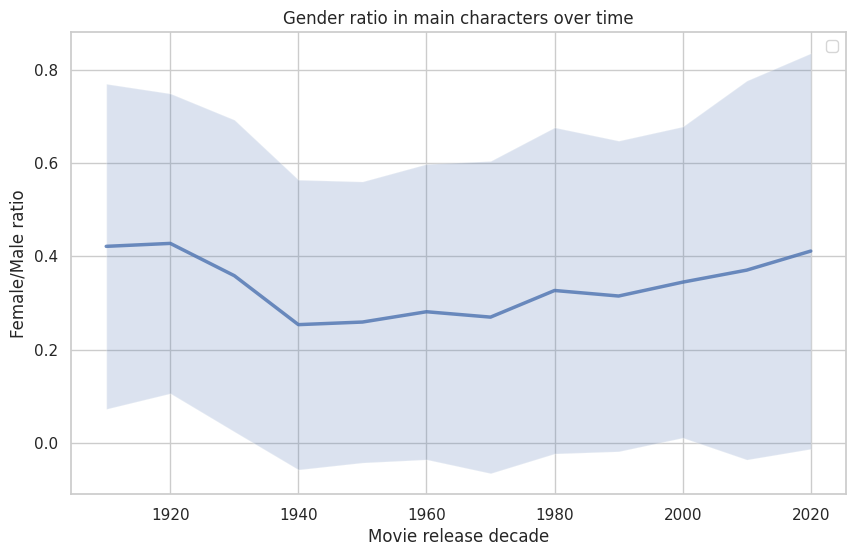

In [116]:
plot_gender_ratio(final_movies)

We observe an upwards trend, suggesting that female main characters have increased in popularity. This preliminary analysis is interesting and we conclude that additional investigation into main characters is warranted.

Our method does however present limitations:
1) Most mentioned characters does not necessarily mean "main" character.
2) We do not detect characters that are not mentioned by name (e.g. "teacher", "general").
3) We miss some characters for which the name in the text is not similar enough to the official name.
4) We only observe the first 5 sentences of each summary as well as max 20 movies per year.

We aim to adress these limitations for the final project milestone by reviewing our approach and by running the final pipeline on a larger dataset.